# Otimizacao_Metaheuristica
<h2> Informações</h2>
Centro Federal de Educação Tecnológia Celso Suckow da Fonseca (CEFET/RJ)<br />
Trabalho da Disciplina: Otimização por Metaurísticas - Semestre 2022/02<br />

Artigo Base:
The Knapsack Problem with Forfeits
Cerulli, R., D’Ambrosio, C., Raiconi, A., Vitale, G. (2020). The Knapsack Problem with Forfeits. In: Baïou, M., Gendron, B., Günlük, O., Mahjoub, A.R. (eds) Combinatorial Optimization. ISCO 2020. Lecture Notes in Computer Science(), vol 12176. Springer, Cham. https://doi.org/10.1007/978-3-030-53262-8_22

<h2> Ações</h2><br/>

- [x] Viabilização de Instâncias
- [x] Algoritmos Construtivos (Guloso, Semi-Guloso, Aleatório)
- [X] Ajuste Algoritmo Construtivo com Penalidades
- [X] Framework GRASP
- [X] Algoritmo com Busca Local
- [X] Execução: 10x para cada Instância
- [X] Reportar Tabela: Melhor Solução
- [X] Reportar Tabela: Média da Solução
- [X] Reportar Tabela: Média do Tempo
- [X] Reportar Tabela: Coeficiente/Desvio de Variação das Soluções
- [X] Reportar Tabela: Coeficiente de Variação do Tempo

        

<h3>Classe para Leitura das Instâncias

In [2]:
import sys
import time

import numpy as np



class Instance:
    def __init__(self, filename):

        path = f"{filename}"

        f = open(path, "r")

        self.num_items, self.num_forfeits_pairs, self.budget = map(
            int, f.readline().split(" ")
        )

        f.close()

        # items definition
        items = []
        for i in range(self.num_items):
            items.append(i)

        self.items = np.array(items)

        line_counter = 1

        self.profits = np.loadtxt(
            path, delimiter=" ", skiprows=line_counter, max_rows=1
        )
        line_counter += 1

        self.weights = np.loadtxt(
            path, delimiter=" ", skiprows=line_counter, max_rows=1
        )
        line_counter += 1

        max = 2 * self.num_forfeits_pairs

        self.forfeit_cost_and_forfeits_pairs = np.loadtxt(
            path, delimiter=" ", skiprows=line_counter, max_rows=max, usecols=(0, 1)
        ).tolist()

        self.forfeits_costs = [
            v for i, v in enumerate(self.forfeit_cost_and_forfeits_pairs) if i % 2 == 0
        ]

        self.forfeits_pairs = [
            v for i, v in enumerate(self.forfeit_cost_and_forfeits_pairs) if i % 2 != 0
        ]

        # remove the first element of the sublist
        for i in range(len(self.forfeits_costs)):
            self.forfeits_costs[i].pop(0)

        # transform list of lists into a single list - flatten
        self.forfeits_costs = [
            item for sublist in self.forfeits_costs for item in sublist
        ]

        self.forfeits_costs = np.array(self.forfeits_costs)
        self.forfeits_pairs = np.array(self.forfeits_pairs)      

<h2>Montando a Matriz de Penalidades

In [3]:
def calculate_penalty(items,forfeits_pairs, forfeits_costs):
    mD=np.zeros((int(len(items)),int(len(items))))       
    
    for index, pair in enumerate(forfeits_pairs):
        mD[int(pair[0]),int(pair[1])]=forfeits_costs[index]                
    return mD

#with np.printoptions(edgeitems=500):
#    print(problem_instance.forfeits_pairs)

<h1>Algoritmo Construtivo (Guloso, Aleatório e Semi-Guloso)</h1>

In [4]:
import random as rd

def greedyalgorithm2(items, weights, profits, budget, forfeits, forfeits_costs, alpha,mD):    
    #solution = np.array([])
    solution = []
    remaining_items = items
    cost = 0
    index = 0
    scost=[]
    sweights=[]
    # print(f"pesos: {weights}")
    # print(f"lucros: {profits}")

    # budget = 25

    while budget > 0 and remaining_items.size != 0:
        # critério guloso ou custo benefício
        H = np.array([])

        # lista restrita de candidatos
        lcr = np.array([])

        # print(f"itens restantes:{remaining_items}")
#         print(f"solucao: {solution}")
        for item in remaining_items:
            h_i = profits[item] / weights[item]
            H = np.append(H, h_i)

        i_max = np.argmax(H)
        i_min = np.argmin(H)

        H_zip = zip(H, remaining_items)

        # o cálculo dos limites da lcr
        ub = H[i_max] + alpha * (H[i_min] - H[i_max])
        lb = H[i_min]

        # print(f"custo benefícios: {H}")
        # print(f"bounds: {(lb,ub)}")

        if alpha == 0:  # aleatório

            candidate = int(np.random.choice(remaining_items))
            penalidade=sum(mD[int(candidate)][solution])   
            budget = budget - weights[candidate]
            cost = cost + profits[candidate]-penalidade
            scost.append( profits[candidate]-penalidade)
                
            sweights.append(weights[candidate])
            #solution = np.append(solution, candidate)
            solution.append(candidate)
            remaining_items = np.delete(
                remaining_items, np.argwhere(remaining_items == candidate)
            )
        elif alpha == 1:  # guloso

            for h_i, item in H_zip:
                if H[i_max] == h_i:
                    candidate = item
            penalidade=sum(mD[int(candidate)][solution])   
            #print(penalidade)
            budget = budget - weights[candidate]
            cost = cost + profits[candidate]-penalidade
            scost.append(profits[candidate]-penalidade)
                
            sweights.append(weights[candidate])
            solution.append(candidate)
            remaining_items = np.delete(
                remaining_items, np.argwhere(remaining_items == candidate)
            )

        else:  # semi-guloso

            for h_i, item in H_zip:
                if h_i >= lb and h_i <= ub:
                    lcr = np.append(lcr, item)

            # print(f"lista de candidatos: {lcr}")

            candidate = int(np.random.choice(lcr))
            penalidade=sum(mD[int(candidate)][solution])   
            budget = budget - weights[candidate]
            cost = cost + profits[candidate]-penalidade
            scost.append( profits[candidate]-penalidade)               
            sweights.append(weights[candidate])
            #solution = np.append(solution, candidate)
            solution.append(candidate)
            remaining_items = np.delete(
                remaining_items, np.argwhere(remaining_items == candidate)
            )

    #print(f'cost: {cost}')
    #print(f'solution: {solution}')
          

    return solution,cost,budget,scost,sweights,remaining_items


def greedyalgorithm(items, weights, profits, budget, forfeits, forfeits_costs, alpha,mD):    
    
    cap=budget    

    #print(sorted_items)    
    solution=[]
    scost=[]
    sweights=[]
    cost=0
    index=0
    
    if alpha == 0:  # totalmente aleatório 
        remaining_items=zip(items,weights,profits)
        sorted_items=sorted(remaining_items, key= lambda x:x[2]/(x[1]+1), reverse=True)
        #print(tuple(items))        
        
        rd_index=rd.choice(range(0,len(sorted_items))) 
        candidate=sorted_items[rd_index][0]
        
        while cap-weights[candidate]>0:                                        
                cap=cap-weights[candidate]
                solution.append(candidate) 
                
                
                penalidade=sum(mD[candidate][solution])                
                #if penalidade>0: print(f"Penalidade do Item {sorted_items[rd_index][0]} é {penalidade}")
                    
                cost=cost+profits[candidate]-penalidade
                
                scost.append(profits[candidate]-penalidade)
                
                sweights.append(weights[candidate])
                
                sorted_items.remove(sorted_items[rd_index])
                rd_index=rd.choice(range(0,len(sorted_items)))  
                candidate=sorted_items[rd_index][0]
        
                    
    else:
            if alpha == 1: #totalmente guloso
                remaining_items=zip(items,weights,profits)
                #print(tuple(items))
                sorted_items=sorted(remaining_items, key= lambda x:x[2]/(x[1]+1), reverse=True)
                #sorted_items=sorted(remaining_items, key= lambda x:x[2]/x[1], reverse=True)
                #print(sorted_items)
                candidate=sorted_items[0][0]
                while cap-weights[candidate]>0:                                                  
                    
                    #calcula a nova penalidade para o item a ser inserido no conjunto e reordena                                      
                    #sorted_items=sorted(sorted_items, key= lambda x:(x[2]/x[1])-sum(mD[x[0]][solution]), reverse=True)                                        
                    
                    cap=cap-weights[candidate]
                    solution.append(candidate)  
                    
                    penalidade=sum(mD[candidate][solution])                
                    #if penalidade>0: print(f"Penalidade do Item {sorted_items[0][0]} é {penalidade}")
                    
                    #cost=cost+sorted_items[0][2]
                    cost=cost+profits[candidate]-penalidade
                    #cost=cost+sorted_items[index][2]-sum(mD[sorted_items[index][0]][solution])
                    
                    scost.append(profits[candidate]-penalidade)
                    
                    sweights.append(weights[candidate])
                    
                    #sorted_items=sorted(sorted_items, key= lambda x:(x[2]-sum(mD[x[0]][solution]))/(x[1]+1), reverse=True)                                        
                    sorted_items.remove(sorted_items[0])
                    
                    if len(sorted_items)>=0:
                        #sorted_items=sorted(sorted_items, key= lambda x:(x[2]-sum(mD[x[0]][solution]))/(x[1]+1), reverse=True)                                        
                        candidate=sorted_items[0][0]
                    #sorted_items.remove(sorted_items[index])
                    #index=index+1  
                    
            else: # semi-guloso
                remaining_items=zip(items,weights,profits,profits/weights)
                sorted_items=sorted(remaining_items, key= lambda x:x[2]/(x[1]+1), reverse=True)
                
                
                # o cálculo dos limites da lcr
                hmax=sorted_items[0][3]
                hmin=sorted_items[-1][3]

                    #ub = hmax + alpha * (hmin - hmax)
                lb = hmin                            
                ub=hmax + alpha * (hmin - hmax)                  

                    #lista restrita de candidatos
                    #lcr=list(filter(lambda x: x[3]<=ub and x[3] >= lb, sorted_items))                                
                lcr=list(filter(lambda x: x[3]>=ub, sorted_items))
                rd_index=rd.choice(range(0,len(lcr))) 
                candidate=lcr[rd_index][0]
                
                #print(candidate)
                while cap-weights[candidate]>0:  
                                                                          
                    cap=cap-weights[candidate]
                    solution.append(candidate)    
                    #print(f" Solution: {solution}")
                                        
                    
                    #penalidade
                    penalidade=sum(mD[candidate][solution])                
                    #if penalidade>0: print(f"Penalidade do Item {sorted_items[rd_index][0]} é {penalidade}")
                                        
                    cost=cost+profits[candidate]-penalidade                                        
                    
                    scost.append(profits[candidate]-penalidade)
                    
                    sweights.append(weights[candidate])
                
                    #removendo o item já inserido
                    sorted_items.remove(sorted_items[sorted_items.index(lcr[rd_index])])                    
               
                                          
                    #sorted_items.sort(key= lambda x:(x[2]-sum(mD[x[0]][solution]))/(x[1]+1), reverse=True)                                        

                     # o cálculo dos limites da lcr
                    hmax=sorted_items[0][3]
                    hmin=sorted_items[-1][3]
                    
                    #ub = hmax + alpha * (hmin - hmax)
                    lb = hmin                            
                    ub=hmax + alpha * (hmin - hmax)
                 
                    #lista restrita de candidatos                                
                    lcr=list(filter(lambda x: x[3]>=ub, sorted_items))

                    #print(f"LCR: {lcr}")
                    rd_index=rd.choice(range(0,len(lcr))) 
                    candidate=lcr[rd_index][0]
                                
    
    return solution,cost,cap,scost,sweights,sorted_items

Teste Curto

In [5]:
pasta = '../input/instances/instances/'
filename = pasta+"500/kpf_1.txt"
print(filename)
problem_instance = Instance(filename)

mD=calculate_penalty(problem_instance.items,problem_instance.forfeits_pairs, problem_instance.forfeits_costs)
start_time = time.time()
alpha=0.7
solution,cost,cap,scost,sweights,sorted_items = greedyalgorithm(
    problem_instance.items,
    problem_instance.weights,
    problem_instance.profits,
    problem_instance.budget,
    problem_instance.forfeits_costs,
    problem_instance.forfeits_pairs,
    alpha,
    mD,
)

#print(problem_instance.forfeits_pairs)

end_time = time.time()

wall_time = end_time - start_time


print(wall_time)
print(f"Custo {cost}")
print(f"Solução {solution}")

../input/instances/instances/500/kpf_1.txt
0.018694162368774414
Custo 1425.0
Solução [327, 478, 186, 446, 382, 37, 202, 21, 290, 482, 296, 171, 476, 471, 63, 226, 173, 247, 220, 95, 488, 271, 187, 311, 19, 234, 425, 59, 427, 17, 99, 309, 40, 491, 163, 317, 456, 18, 92, 480, 395, 79, 241, 239, 135, 229, 161, 253, 346, 219, 192, 353, 22, 450, 256, 463, 77, 178, 66, 257, 116, 90, 14, 130, 262, 227, 366, 402, 82, 117, 364, 337, 300, 380, 38, 174, 73, 39, 359, 457, 44, 196, 356, 413, 254, 150, 9, 297, 211, 295, 145, 495, 204, 170, 265, 224, 101, 54, 5, 481, 464, 473, 72, 310, 314, 367, 406, 87, 315, 159, 245, 209, 56, 102, 151, 138, 328, 107, 341, 440, 16, 111, 411, 409, 398, 348, 127, 246, 329, 434, 410, 396, 417, 455, 363, 374, 96, 98, 437, 195, 232, 4, 108, 157, 344, 477, 452, 0, 162, 160, 213, 31, 238, 423, 41, 175, 105, 182, 486, 370, 199, 142, 373, 276, 47, 299, 91, 11, 134, 264, 148, 386, 181, 177, 193, 312, 76, 485, 156, 467, 244, 188, 279, 438, 416, 362, 407, 303, 12, 489, 42, 251,

<h1>Algoritmo de Busca Local

Primeira Melhora
Este método de melhoria explora a vizinhança de troca,ou seja, ele troca um elemento aleatória na mochila com um elemente de fora, respeitando o limite de capacidade, e buscando uma melhoria na função que objetiva o maior lucro.

In [6]:
def busca_local(solution,cost,scost,sweights1,sorted_items,cap):
    #cap capacidade restante
    #sorted_items  items que nao foram incluidos na solucao anterior
    s1=solution
    scost1=scost
    cost1=cost
    scap1=cap
   
    s_mudou=False
    s1_items=zip(s1,sweights1,scost1)
       
    
    s1_items=sorted(s1_items, key= lambda x:x[2]/(x[1]+1), reverse=True)
    
    size_s1=len(s1_items)
    
    
    size_items=len(sorted_items)
    cont_solucao=size_s1-1
    
    #enquanto nao encontrar melhoria e nao percorrer toda a solucao original
    while s_mudou==False and cont_solucao>=0:        
    
        #pegando o proximo item (do pior beneficio custo na solucao em diante)
        bad_item=s1_items[cont_solucao][0]
        
                
        #verificando a capacidade da mochila que deverá ser ocupada               
        scapaux=scap1+s1_items[cont_solucao][1]

        #ordenando os itens restantes da mochila, a partir do critério guloso        
        sorted_items=sorted(sorted_items, key= lambda x:(x[2]-sum(mD[x[0]][s1]))/(x[1]+1), reverse=True)
        j=0        
        #percorrendo os itens que nao entraram na mochila, para verificar se algum pode substituir
        while scapaux-sorted_items[0][1]>0 and j<len(sorted_items): 
            
  
            sweights1.append(sweights1[s1.index(s1_items[cont_solucao][0])])

            penalidade=sum(mD[sorted_items[0][0]][s1])                
            #if penalidade>0: print(f"Penalidade do Item {sorted_items[0][0]} é {penalidade}")

           
            cost1=cost+sorted_items[0][2]-penalidade
           
            
            #fazer o teste para verificar se o resultado da solucao anterior é melhor que resultado da solucao antiga
            if cost1>cost:            
                s_mudou=True
                
                #print(f"COST Anterior:{cost}\n Novo COST {cost1}\n Novo Item{sorted_items[j][0]} \n Item Retirado{s1[s1.index(s1_items[cont_solucao][0])]}")
                
                print(f" Novo Item: {sorted_items[0][0]} \n Item Retirado: {s1[s1.index(s1_items[cont_solucao][0])]}")
                #print(f" Novo Item: {sorted_items[j][0]} \n Item Retirado: {s1[s1.index(s1_items[cont_solucao][0])]}")
                
                #adiciona na nova solucao o item
                s1.append(sorted_items[0][0])  
                
                scapaux=scapaux-sorted_items[0][1]   
                scost1.append(sorted_items[0][2]-penalidade)
                sweights1.append(sorted_items[0][1])
                
                sorted_items.remove(sorted_items[0])  
                scost1.remove(scost1[s1.index(s1_items[cont_solucao][0])])
                s1.remove(s1[s1.index(s1_items[cont_solucao][0])])                                                
                cost=cost1
                scap1=scapaux
                break;            
                
                
            sorted_items=sorted(sorted_items, key= lambda x:(x[2]-sum(mD[x[0]][s1]))/(x[1]+1), reverse=True)    
            j=j+1
            
        #verifica se a solução proposta é melhor que a atual          
        if s_mudou==True:
            return s1,cost1,scost1,scap1,sweights1,sorted_items
        else:
            cont_solucao=cont_solucao-1 
            #if cont_solucao<214:
                #s_mudou==True
    
    if s_mudou==False:
        return solution,cost,scost,cap,sweights1,sorted_items
    else:
        return s1,cost1,scost1,scap1,sweights1,sorted_items

<h1>GRASP

In [7]:
def grasp(max_iterations,items, weights, profits, budget, forfeits_pairs, forfeits_costs, alpha,mD):
    
    solution_final=0
    cost_final=0;
    cost_aux=0;
    while max_iterations>=0:
        solution,cost,cap,scost,sweights,sorted_items = greedyalgorithm(
        items,
        weights,
        profits,
        budget,
        forfeits_pairs,
        forfeits_costs,
        alpha,
        mD,)
        
        s1,cost1,scost1,scap1,sweights1,sorted_items1= busca_local(solution,cost,scost,sweights,sorted_items,cap)
        
        if cost>cost1:
            cost_aux=cost
            solution_aux=solution
        else:
            cost_aux=cost1
            solution_aux=s1
        print(solution_aux)
        print(cost_aux)
        
        if cost_aux>cost_final:
            cost_final=cost_aux
            solution_final=solution_aux
        
        max_iterations=max_iterations-1
    

    return solution_final,cost_final

<h2>Funções Auxiliares (Caso Necessário)

<h3>Função para Cálculo do Lucro dos itens constantes como solução(incluídos na mochila)

In [8]:
def calcCost(solution, profits):
    cost = 0
    for sol in solution:
        sol = int(sol)
        cost = cost + profits[sol]
    return cost

<h3> Função Para Cálculo da Capacidade da Mochila

In [9]:
def calcb(solution, w):
    bres = 0
    for sol in solution:
        sol=int(sol)
        bres = bres + int(w[sol])
    return bres

<h2> Iniciando a Execução

<h3>Buscando os Arquivos das Instâncias

In [10]:
import os
pasta = '../input/instances/instances/500/'
#pasta = 'instances/500/'
instancias=[]
name_instancias=[]
for diretorio, subpastas, arquivos in os.walk(pasta):
    for arquivo in arquivos:
        instancias.append(os.path.join("500/", arquivo))
        name_instancias.append(arquivo.split(".")[0])
print(instancias)
print(name_instancias)

['500/kpf_7.txt', '500/kpf_8.txt', '500/kpf_3.txt', '500/kpf_4.txt', '500/kpf_9.txt', '500/kpf_2.txt', '500/kpf_6.txt', '500/kpf_5.txt', '500/kpf_10.txt', '500/kpf_1.txt']
['kpf_7', 'kpf_8', 'kpf_3', 'kpf_4', 'kpf_9', 'kpf_2', 'kpf_6', 'kpf_5', 'kpf_10', 'kpf_1']


<h2> Lista de Algoritmos para Execução

In [11]:
import numpy as np
algoritmos = np.array(["Guloso","Aleatorio","SemiGuloso","GRASP"])
#algoritmos = np.array(["Guloso","Aleatorio","SemiGuloso"])

<h3>Criando o Diretório para guardar os resultados

In [12]:
pasta_result = '/kaggle/working/result'
if not os.path.isdir(pasta_result): # vemos de este diretorio ja existe
    os.mkdir(pasta_result) # aqui criamos a pasta caso nao exista

In [13]:
#Apagando o Diretório dos Resultados

#import shutil
#shutil.rmtree("/kaggle/working/result")
#instancias[3]

<h1>Realizando para todas as instâncias e algoritmos da Lista

In [14]:
mD=calculate_penalty(problem_instance.items,problem_instance.forfeits_pairs, problem_instance.forfeits_costs)
pasta = '../input/instances/instances/'
#filename = pasta+"500/kpf_1.txt"
#problem_instance = Instance(filename)
#pasta = 'instances/'
for inst in instancias:    
    #filename = pasta+inst
    print(filename)
    problem_instance = Instance(filename)
    mD=calculate_penalty(problem_instance.items,problem_instance.forfeits_pairs, problem_instance.forfeits_costs)
    for alg in algoritmos:
        if alg=="Aleatorio":
                alpha=float(0)
        else:
            if alg=="Guloso":
                alpha=float(1)
            else:
                if alg=="SemiGuloso" or alg=="GRASP":
                    alpha = float(0.7)                
                        
        for i in range(1, 11):
        #for i in range(1, 2):
            if alg!="GRASP":            
                start_time = time.time()                 
                solution,cost,cap,scost,sweights,sorted_items = greedyalgorithm(
                #solution,cost,scost,cap,sweights1,sorted_items= greedyalgorithm(
                    problem_instance.items, problem_instance.weights, problem_instance.profits,
                    problem_instance.budget, problem_instance.forfeits_pairs, problem_instance.forfeits_costs,
                    alpha,
                    mD,)
                end_time = time.time()
                wall_time = end_time - start_time
            else:
                max_iterations=50
                start_time = time.time()                                 
                solution,cost=grasp(
                    max_iterations,
                    problem_instance.items,
                    problem_instance.weights,
                    problem_instance.profits,
                    problem_instance.budget,
                    problem_instance.forfeits_pairs,
                    problem_instance.forfeits_costs,
                    alpha,
                    mD,)
                end_time = time.time()
                wall_time = end_time - start_time
                

            #cost=calcCost(solution,problem_instance.profits)
            f = open(f"{pasta_result}/resultados_algoritmo_{alg}_instancia_{name_instancias[instancias.index(inst)]}.txt", "a")

            f.write(f"execucao_{i} para {inst}:\n")
            print(f"execucao_{i} para {inst}:\n")
            f.write(f"-> alpha: {alpha}\n")
            f.write(f"-> custo solucao : {cost}\n")
            f.write(f"-> tempo: {wall_time}\n")
            #f.write(f"-> solucao: {solution}\n")

            f.write(f"\n")
            f.write(f"\n")
            f.close()
            
            if alg!="GRASP":
            #if alg=="GRASP":
                start_time1 = time.time()                 
                s1,cost1,scost1,scap1,sweights1,sorted_items1= busca_local(solution,cost,scost,sweights,sorted_items,cap)
                end_time1 = time.time()
                wall_time1 = end_time1 - start_time1

                fbl = open(f"{pasta_result}/resultados_busca_local_algoritmo_{alg}_instancia_{name_instancias[instancias.index(inst)]}.txt", "a")
                fbl.write(f"Busca Local execucao_{i} para {inst}:\n")
                print(f"BUSCA LOCAL execucao_{i} para {inst}:\n")
                fbl.write(f"-> alpha: {alpha}\n")
                fbl.write(f"-> custo solucao : {cost1}\n")
                fbl.write(f"-> tempo: {wall_time1+wall_time}\n")
                #fbl.write(f"-> solucao: {s1}\n")
                fbl.write(f"\n")
                fbl.close()

../input/instances/instances/500/kpf_1.txt
execucao_1 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_1 para 500/kpf_7.txt:

execucao_2 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_2 para 500/kpf_7.txt:

execucao_3 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_3 para 500/kpf_7.txt:

execucao_4 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_4 para 500/kpf_7.txt:

execucao_5 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_5 para 500/kpf_7.txt:

execucao_6 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_6 para 500/kpf_7.txt:

execucao_7 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_7 para 500/kpf_7.txt:

execucao_8 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retirado: 41
BUSCA LOCAL execucao_8 para 500/kpf_7.txt:

execucao_9 para 500/kpf_7.txt:

 Novo Item: 104 
 Item Retira

<h1>Extraindo os resultados Obtidos

In [15]:
pasta = '../input/instances/instances/'
from tabulate import tabulate
d=[]
d2=[]
for inst in instancias:   
    filename = pasta+inst
    problem_instance = Instance(filename)
    for alg in algoritmos:
        if alg=="Guloso":
            nalg=1
        elif alg=="Aleatorio":
            nalg=0
        elif alg=="SemiGuloso":
            nalg=2
        elif alg=="GRASP":
            nalg=3
        

        f = open(f"{pasta_result}/resultados_algoritmo_{alg}_instancia_{name_instancias[instancias.index(inst)]}.txt", "r")
        arquivo = f.readlines()                
        
        if alg!="GRASP":
        #if alg=="GRASP":
            fbl = open(f"{pasta_result}/resultados_busca_local_algoritmo_{alg}_instancia_{name_instancias[instancias.index(inst)]}.txt", "r")        
            arquivobl = fbl.readlines()
            custo_bl=[]
            tempo_bl=[]
            local_custo_bl=0
            local_tempo_bl=0
        
        local_custo=0        
        local_tempo=0        
   
        custo=[]
        tempo=[]
        
        for i in range(0, 10):
        #for i in range(0, 1):
            
            local_custo=(arquivo[(i*6)+2].split("-> custo solucao : ")[1]).strip('\n')
            #print(arquivo[(i*6)+3].split("-> tempo: ")[1])
            local_tempo=(arquivo[(i*6)+3].split("-> tempo: ")[1]).strip('\n')
            
            d.append((alg,name_instancias[instancias.index(inst)], i+1,local_custo,local_tempo))
            #custo=custo+float(local_custo)
            #tempo=tempo+float(local_tempo)
            custo.append(float(local_custo))
            tempo.append(float(local_tempo))
            
            
            if alg!="GRASP":
            #if alg=="GRASP":
            
                local_custo_bl=(arquivobl[(i*5)+2].split("-> custo solucao : ")[1]).strip('\n')
                #print(arquivobl[(i*5)+3].split("-> tempo: ")[1])
                local_tempo_bl=(arquivobl[(i*5)+3].split("-> tempo: ")[1]).strip('\n')

                d.append((alg+"_BL",name_instancias[instancias.index(inst)], i+1,local_custo_bl,local_tempo_bl))
                
                custo_bl.append(float(local_custo_bl))
                tempo_bl.append(float(local_tempo_bl))
            
            
        
        #media
        #print(custo)
        media_custo=np.mean(custo)
        media_tempo=np.mean(tempo)
        #variancia
        coefvar_custo=np.var(custo)
        coefvar_tempo=np.var(tempo)
        
        
        #desvio padrao
        stdvar_custo=np.std(custo)
        stdvar_tempo=np.std(tempo)
        
        if alg!="GRASP":
        #if alg=="GRASP":
            media_custo_bl=np.mean(custo_bl)
            media_tempo_bl=np.mean(tempo_bl)
            coefvar_custo_bl=np.var(custo_bl)
            coefvar_tempo_bl=np.var(tempo_bl)
            stdvar_custo_bl=np.std(custo_bl)
            stdvar_tempo_bl=np.std(tempo_bl)
            d2.append((alg+"_BL",name_instancias[instancias.index(inst)],media_custo_bl,coefvar_custo_bl/100,stdvar_custo_bl,
                  media_tempo_bl,coefvar_tempo_bl,stdvar_tempo_bl))

        
        
        d2.append((alg,name_instancias[instancias.index(inst)],media_custo,coefvar_custo/100,stdvar_custo,
                   media_tempo,coefvar_tempo,stdvar_tempo))
                  

print(tabulate(d, headers=["Algoritmo","Instancia","Execucao","Custo","Tempo"]))

print("\n\n\n")

c = open(f"{pasta_result}/resultado_consolidado.txt", "a")
resultc=tabulate(d, headers=["Algoritmo","Instancia","Execucao","Custo","Tempo"])
c.write("\n\n")
c.write(resultc)
print(resultc)
c.close()

Algoritmo      Instancia      Execucao    Custo       Tempo
-------------  -----------  ----------  -------  ----------
Guloso         kpf_7                 1     1767  0.00520182
Guloso_BL      kpf_7                 1     1781  0.0557532
Guloso         kpf_7                 2     1767  0.00522137
Guloso_BL      kpf_7                 2     1781  0.0637298
Guloso         kpf_7                 3     1767  0.00511336
Guloso_BL      kpf_7                 3     1781  0.0571132
Guloso         kpf_7                 4     1767  0.00490737
Guloso_BL      kpf_7                 4     1781  0.0582719
Guloso         kpf_7                 5     1767  0.00489998
Guloso_BL      kpf_7                 5     1781  0.057147
Guloso         kpf_7                 6     1767  0.00496149
Guloso_BL      kpf_7                 6     1781  0.0566115
Guloso         kpf_7                 7     1767  0.00492048
Guloso_BL      kpf_7                 7     1781  0.0575011
Guloso         kpf_7                 8     1767 

<h1>Apresentando os Resultados Obtidos, Ordenando pelo Melhor Custo

In [16]:
import pandas as pd
df = pd.DataFrame(d2,columns=["Algoritmo","Instancia","Md Custo","Coef VAR(%)-Custo ","Desv Pd-Custo","Md Tempo","Coef VAR(%)-TEMPO","Desv Pd-TEMPO"])

In [17]:
 def color_row3(x):
    bc = []
    d=""
    c='background-color: '
    for i in range(0,len(x)):
        if (i+7)%7==0:
            if c=='background-color:  #c2c2d6':
                c='background-color:  #b3ffff'
            else:
                c='background-color:  #c2c2d6'
            d=d+';color: red; font-weight:bold'
            #d=d+';color: black; font-weight:bold'
        else:
            d=d+';color:black'        
        bc.append(c+d)        
        d=""
    return bc
#color_row3(d2)
df.sort_values(['Instancia','Md Custo'],ascending=False).style.apply(color_row3)

Resultado Totalizado

In [18]:
d3=[]

for ninst in name_instancias:        
    df_local=df[df["Instancia"]==ninst]
       
    #d3.append((ninst,media_custo,coefvar_custo/100,stdvar_custo,media_tempo,coefvar_tempo,stdvar_tempo))
    
    media_custo=np.mean(df_local['Md Custo'])
    media_tempo=np.mean(df_local['Md Tempo'])

    #variancia
    coefvar_custo=np.var(df_local['Md Custo'])
    coefvar_tempo=np.var(df_local['Md Tempo'])

    #desvio padrao
    stdvar_custo=np.std(df_local['Md Custo'])
    stdvar_tempo=np.std(df_local['Md Tempo'])
    d3.append((ninst,media_custo,coefvar_custo/100,stdvar_custo,
                   media_tempo,coefvar_tempo/100,stdvar_tempo))
        

    
df2 = pd.DataFrame(d3,columns=["Instancia","Md Custo","Coef VAR(%)-Custo ","Desv Pd-Custo","Md Tempo","Coef VAR(%)-TEMPO","Desv Pd-TEMPO"])

df2.sort_values(['Md Custo'],ascending=False)
#print(custo)
#print(tempo)

Instancia     Md Custo  Coef VAR(%)-Custo   Desv Pd-Custo  Md Tempo  \
6     kpf_6  1597.885714          657.813755     256.478801  0.367146   
2     kpf_3  1590.828571          750.591906     273.969324  0.361827   
4     kpf_9  1579.985714          673.140298     259.449474  0.427743   
8    kpf_10  1573.900000         1012.893629     318.259898  0.503559   
0     kpf_7  1573.428571          847.136420     291.056081  0.473162   
1     kpf_8  1572.971429          803.368049     283.437480  0.375742   
5     kpf_2  1567.042857          818.990082     286.180028  0.493050   
9     kpf_1  1556.628571         1009.560963     317.735891  0.446066   
7     kpf_5  1553.285714          881.608469     296.918923  0.373572   
3     kpf_4  1544.800000          931.033914     305.128483  0.456024   

   Coef VAR(%)-TEMPO  Desv Pd-TEMPO  
6           0.007072       0.840965  
2           0.006883       0.829660  
4           0.009844       0.992184  
8           0.013841       1.176486  
0           0.012206       1.104809  
1           0.007452       0.863244  
5           0.013216       1.149619  
9           0.010803       1.039360  
7           0.007208       0.848973  
3           0.009427       0.970952

<h1>Representações Gráficas

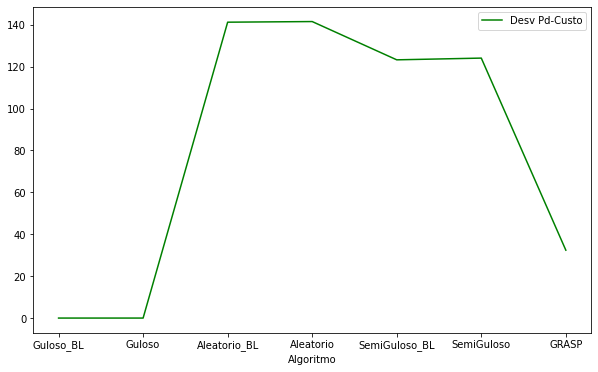

In [19]:
import matplotlib.pyplot as plt
#Coef VAR(%)-Custo	Desv Pd-Custo	Md Tempo	Coef VAR(%)-TEMPO	Desv Pd-TEMPO
df_kpf_1=df[df['Instancia']=='kpf_1']

ax = plt.gca()
#df_kpf_1.plot(kind='line', x='Algoritmo', y='Md Custo', color='blue', ax=ax, figsize=(10,6))
df_kpf_1.plot(kind='line', x='Algoritmo', y='Desv Pd-Custo', color='green', ax=ax, figsize=(10,6))
#df_kpf_1.plot(kind='line', x='Algoritmo', y='Coef VAR(%)-TEMPO', color='yellow', ax=ax, figsize=(10,6))


plt.show()



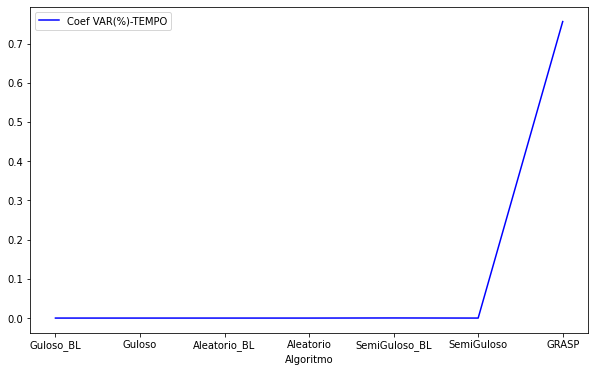

In [20]:
ax = plt.gca()
#df_kpf_1.plot(kind='line', x='Algoritmo', y='Md Tempo', color='blue', ax=ax, figsize=(10,6))
#df_kpf_1.plot(kind='line', x='Algoritmo', y='Desv Pd-Custo', color='green', ax=ax, figsize=(10,6))
df_kpf_1.plot(kind='line', x='Algoritmo', y='Coef VAR(%)-TEMPO', color='blue', ax=ax, figsize=(10,6))
plt.show()



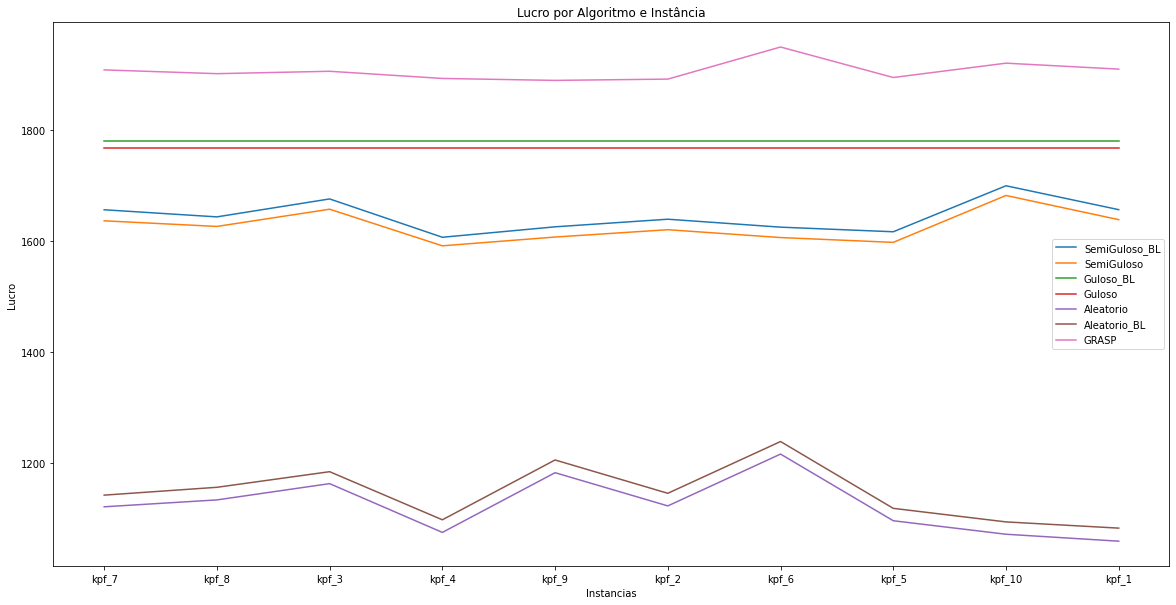

In [21]:

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df[df['Algoritmo']=='SemiGuloso_BL']['Instancia'], df[df['Algoritmo']=='SemiGuloso_BL']['Md Custo'], label='SemiGuloso_BL')
ax.plot(df[df['Algoritmo']=='SemiGuloso']['Instancia'], df[df['Algoritmo']=='SemiGuloso']['Md Custo'], label='SemiGuloso')
ax.plot(df[df['Algoritmo']=='Guloso_BL']['Instancia'], df[df['Algoritmo']=='Guloso_BL']['Md Custo'], label='Guloso_BL')
ax.plot(df[df['Algoritmo']=='Guloso']['Instancia'], df[df['Algoritmo']=='Guloso']['Md Custo'], label='Guloso')
ax.plot(df[df['Algoritmo']=='Aleatorio']['Instancia'], df[df['Algoritmo']=='Aleatorio']['Md Custo'], label='Aleatorio')
ax.plot(df[df['Algoritmo']=='Aleatorio_BL']['Instancia'], df[df['Algoritmo']=='Aleatorio_BL']['Md Custo'], label='Aleatorio_BL')
ax.plot(df[df['Algoritmo']=='GRASP']['Instancia'], df[df['Algoritmo']=='GRASP']['Md Custo'], label='GRASP')
ax.set_xlabel('Instancias')
ax.set_ylabel('Lucro')
ax.set_title("Lucro por Algoritmo e Instância")
ax.legend()
plt.show()

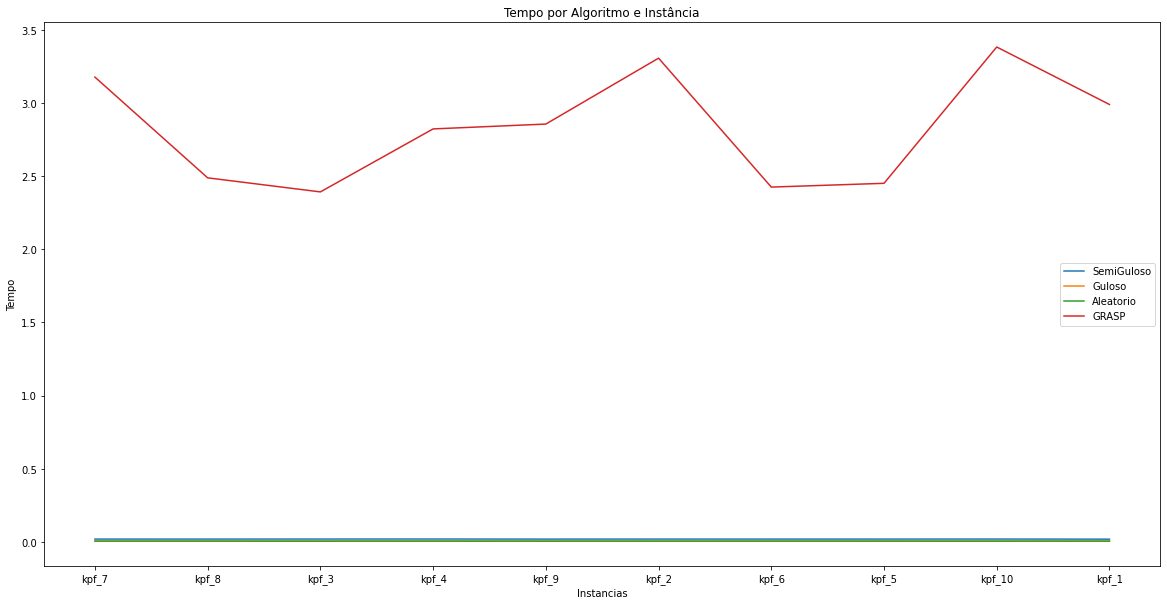

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax.plot(df[df['Algoritmo']=='SemiGuloso_BL']['Instancia'], df[df['Algoritmo']=='SemiGuloso_BL']['Md Tempo'], label='SemiGuloso_BL')
ax.plot(df[df['Algoritmo']=='SemiGuloso']['Instancia'], df[df['Algoritmo']=='SemiGuloso']['Md Tempo'], label='SemiGuloso')
#ax.plot(df[df['Algoritmo']=='Guloso_BL']['Instancia'], df[df['Algoritmo']=='Guloso_BL']['Md Tempo'], label='Guloso_BL')
ax.plot(df[df['Algoritmo']=='Guloso']['Instancia'], df[df['Algoritmo']=='Guloso']['Md Tempo'], label='Guloso')
ax.plot(df[df['Algoritmo']=='Aleatorio']['Instancia'], df[df['Algoritmo']=='Aleatorio']['Md Tempo'], label='Aleatorio')
ax.plot(df[df['Algoritmo']=='GRASP']['Instancia'], df[df['Algoritmo']=='GRASP']['Md Tempo'], label='GRASP')
#ax.plot(df[df['Algoritmo']=='Aleatorio_BL']['Instancia'], df[df['Algoritmo']=='Aleatorio_BL']['Md Tempo'], label='Aleatorio_BL')
ax.set_xlabel('Instancias')
ax.set_ylabel('Tempo')
ax.set_title("Tempo por Algoritmo e Instância")
ax.legend()
plt.show()